<h1>POS tagging using modified Viterbi</h1>





## Assignment - HMMs and Viterbi algorithm for POS tagging

**Approach**
1. Treebank dataset of NLTK with the 'universal' tagset is used for preprocessing
   - Basic text and structure exploration
   - Split the Treebank dataset into train and validation sets with sample size of 95:5
2. Develop POS Tagging Algorithm - HMM
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Develop **vanilla Viterbi Heuristic algorithm** for assigning POS tag and check accuracy on the validation data set
4. Develop **modified Viterbi-1 alogirthm** by using Regex to identify and differentiate unknown words and define     morphorlogical rules to tag them and check accuracy on the validation data set
5. Develop **modified Viterbi-2 algorithm** by identifying mostly used tag in the training corpus and apply it to the unknown word and check accuracy on the validation data set
6. Develop **modified Viterbi-3 algorithm** by using the last three characters of the unknown word and associate the tag from the training set based on the last three characters of word and check accuracy on the validation data set
7. **Generate POS tag on the sample test file** (i.e. unknown word-tag pairs) by using vanilla Viterbi POS tagger and modified Viterbi POS tagger. Conclude by listing down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
import operator as op
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [3]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\ramab\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\treebank.zip.


True

In [6]:
nltk.download('universal_tagset')
wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
print(len(wsj))

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\ramab\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


3914


In [7]:
# first few tagged sentences
print(wsj[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [8]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj, test_size = 0.05, random_state = 42)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.20', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.272', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('2009', 'NUM'), ('.', '.')], [('``', '.'), ('They', 'PRON'), ('wer

In [9]:
train_set[0]

[('Bank', 'NOUN'),
 ('of', 'ADP'),
 ('New', 'NOUN'),
 ('England', 'NOUN'),
 ("'s", 'PRT'),
 ('shares', 'NOUN'),
 ('are', 'VERB'),
 ('traded', 'VERB'),
 ('*-1', 'X'),
 ('on', 'ADP'),
 ('the', 'DET'),
 ('New', 'NOUN'),
 ('York', 'NOUN'),
 ('Stock', 'NOUN'),
 ('Exchange', 'NOUN'),
 ('.', '.')]

In [10]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95589

In [11]:
train_tagged_words

[('Bank', 'NOUN'),
 ('of', 'ADP'),
 ('New', 'NOUN'),
 ('England', 'NOUN'),
 ("'s", 'PRT'),
 ('shares', 'NOUN'),
 ('are', 'VERB'),
 ('traded', 'VERB'),
 ('*-1', 'X'),
 ('on', 'ADP'),
 ('the', 'DET'),
 ('New', 'NOUN'),
 ('York', 'NOUN'),
 ('Stock', 'NOUN'),
 ('Exchange', 'NOUN'),
 ('.', '.'),
 ('$', '.'),
 ('130', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('of', 'ADP'),
 ('general', 'ADJ'),
 ('obligation', 'NOUN'),
 ('distributable', 'ADJ'),
 ('state', 'NOUN'),
 ('aid', 'NOUN'),
 ('bonds', 'NOUN'),
 ('due', 'ADJ'),
 ('1991-2000', 'NUM'),
 ('and', 'CONJ'),
 ('2009', 'NUM'),
 (',', '.'),
 ('tentatively', 'ADV'),
 ('priced', 'VERB'),
 ('*', 'X'),
 ('by', 'ADP'),
 ('a', 'DET'),
 ('Chemical', 'NOUN'),
 ('Securities', 'NOUN'),
 ('Inc.', 'NOUN'),
 ('group', 'NOUN'),
 ('*', 'X'),
 ('to', 'PRT'),
 ('yield', 'VERB'),
 ('from', 'ADP'),
 ('6.20', 'NUM'),
 ('%', 'NOUN'),
 ('in', 'ADP'),
 ('1991', 'NUM'),
 ('to', 'PRT'),
 ('7.272', 'NUM'),
 ('%', 'NOUN'),
 ('in', 'ADP'),
 ('2009', 'NUM'),
 ('.', '.

In [12]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

In [13]:
# vocabulary
V = set(tokens)
print(len(V))

12109


In [14]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [15]:
print(T)

{'X', 'DET', 'VERB', 'ADJ', 'CONJ', 'NOUN', 'ADP', 'ADV', '.', 'PRON', 'PRT', 'NUM'}


## ### Build the vanilla Viterbi based POS tagger



### Emission Probabilities

In [16]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [17]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [18]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [19]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [20]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [21]:
tags_df

,X,DET,VERB,ADJ,CONJ,NOUN,ADP,ADV,.,PRON,PRT,NUM
X,0.076482,0.055131,0.203633,0.016571,0.010357,0.061345,0.142925,0.025175,0.163799,0.056087,0.185787,0.002709
DET,0.045509,0.005311,0.038387,0.204973,0.000483,0.640029,0.009054,0.012313,0.017986,0.003742,0.000241,0.021970
VERB,0.218005,0.133101,0.169189,0.064649,0.005588,0.110904,0.090493,0.082577,0.035312,0.036244,0.031121,0.022817
ADJ,0.021392,0.005101,0.012342,0.066645,0.016949,0.696725,0.078986,0.004608,0.065328,0.000658,0.010861,0.020405
CONJ,0.007977,0.121539,0.153918,0.116847,0.000469,0.349132,0.054435,0.055842,0.034256,0.058658,0.004693,0.042234
NOUN,0.029136,0.013310,0.147978,0.012289,0.041936,0.264632,0.176275,0.016884,0.239179,0.004923,0.043832,0.009627
ADP,0.034029,0.326378,0.008240,0.105297,0.000856,0.321776,0.017228,0.013162,0.039486,0.069128,0.001498,0.062921
ADV,0.023588,0.067110,0.344518,0.130233,0.006312,0.030897,0.119601,0.081063,0.136877,0.015615,0.013621,0.030565
.,0.026623,0.173502,0.088505,0.044972,0.057924,0.223152,0.091114,0.052078,0.093812,0.065389,0.002339,0.080500
PRON,0.092819,0.009549,0.480901,0.074866,0.004966,0.211230,0.022918,0.033995,0.041253,0.008021,0.012223,0.007257


In [22]:
tags_df.loc['.', :]

X       0.026623
DET     0.173502
VERB    0.088505
ADJ     0.044972
CONJ    0.057924
NOUN    0.223152
ADP     0.091114
ADV     0.052078
.       0.093812
PRON    0.065389
PRT     0.002339
NUM     0.080500
Name: ., dtype: float32

In [23]:
tags_df.head()

,X,DET,VERB,ADJ,CONJ,NOUN,ADP,ADV,.,PRON,PRT,NUM
X,0.076482,0.055131,0.203633,0.016571,0.010357,0.061345,0.142925,0.025175,0.163799,0.056087,0.185787,0.002709
DET,0.045509,0.005311,0.038387,0.204973,0.000483,0.640029,0.009054,0.012313,0.017986,0.003742,0.000241,0.021970
VERB,0.218005,0.133101,0.169189,0.064649,0.005588,0.110904,0.090493,0.082577,0.035312,0.036244,0.031121,0.022817
ADJ,0.021392,0.005101,0.012342,0.066645,0.016949,0.696725,0.078986,0.004608,0.065328,0.000658,0.010861,0.020405
CONJ,0.007977,0.121539,0.153918,0.116847,0.000469,0.349132,0.054435,0.055842,0.034256,0.058658,0.004693,0.042234


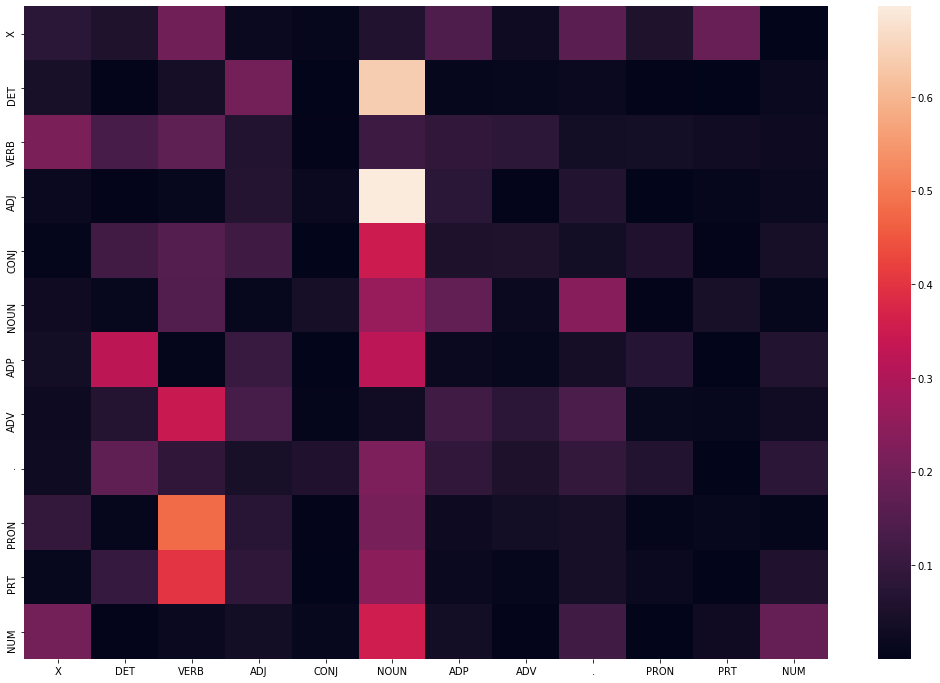

In [24]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


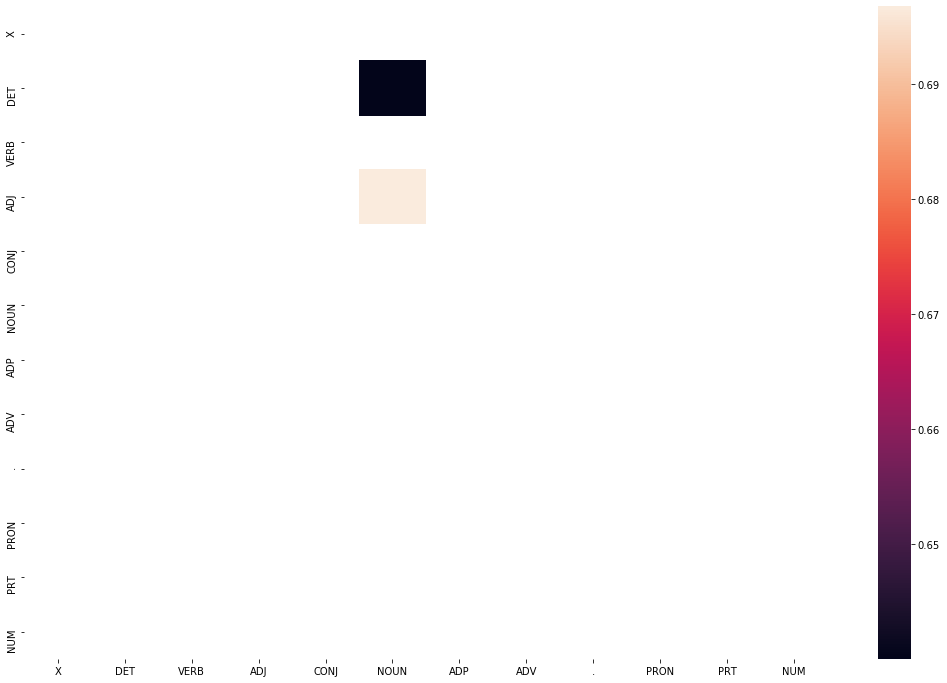

In [25]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

<h1><font color="Green"> Viterbi based POS tagger</font></h1>

Let's now u
se the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [26]:
len(train_tagged_words)

95589

In [27]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    # word and tag pair- e.g  DET, Noun
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


<h1><font color="Green"> Modified Viterbi -1</font></h1>


The following algorithm is based on the Viterbi algorithm. It uses Regex to identify tags of unknown words

In [28]:
# Viterbi Heuristic
def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    # Initialise emission probability
    emission_p = 0
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            # compute emission and state probabilities
            emi_tuple = word_given_tag(word, tag)
            emission_p = emi_tuple[0]/emi_tuple[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        
        # Word not found, override the state_max
        if emission_p == 0 and len(word) > 4:
            # Processing only if more than 4 characters
            if re.match(r'([A-Z]\w+)', word) or re.match(r'\b(\w+ness)\b', word):
                state_max = 'NOUN'
            elif re.match(r'\b(\w+ed)\b', word):
                state_max = 'VERB'
            elif re.match(r'\b(\w+ly)\b', word):
                state_max = 'ADV'
                        
        state.append(state_max)
    return list(zip(words, state))

<h1><font color="Green"> Modified Viterbi -2</font></h1>


The following algorithm is based on the Viterbi algorithm. Identify the TAG used most frequently in the corpus and assigns it for Unknown words

In [29]:
# Viterbi Heuristic
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    # Find the TAG usages
    tag_used, used_count = np.unique([pair[1] for pair in train_tagged_words], return_counts=True)
    
    # Identify the TAG used most frequently
    commTag = max(dict(zip(tag_used, used_count)).items(), key = op.itemgetter(1))[0]
    
    # Initialise emission probability
    emission_p = 0
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            # compute emission and state probabilities
            emi_tuple = word_given_tag(word, tag)
            emission_p = emi_tuple[0]/emi_tuple[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
        
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 

        # Word not found, override the state_max
        if emission_p == 0 and len(word) > 4:
            # Now set the tag which appears most in the training set
            state_max = commTag            
            print ('Word not found', word, state_max)
            
        state.append(state_max)
    return list(zip(words, state))

<h1><font color="Green"> Modified Viterbi -3</font></h1>


The following algorithm is based on the Viterbi algorithm. 
It creates a dynamic pattern using the last three characters of the unknown word. Then it finds the most frequent tag in the training set for words ending with the last three characters

In [30]:
# Viterbi Heuristic
def Viterbi_3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
        
    # Initialise emission probability
    emission_p = 0
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            # compute emission and state probabilities
            emi_tuple = word_given_tag(word, tag)
            emission_p = emi_tuple[0]/emi_tuple[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
        
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 

        # Word not found, override the state_max
        if emission_p == 0 and len(word) > 4:
            # Create dynamic pattern using last 3 characters of the string
            re_pat = r'\b(\w+' + re.escape(word[-4 :]) + r')\b'
            # Create a filtered tagged word list for the matching words
            train_tagged_words_filt = [pair for pair in train_tagged_words if re.match(re_pat, pair[0])]
            
            # Find the TAG usages
            tag_used, used_count = np.unique([pair[1] for pair in train_tagged_words_filt], return_counts=True)
            
            # Identify the TAG used most frequently
            if len(used_count) > 0:
                commTag = max(dict(zip(tag_used, used_count)).items(), key = op.itemgetter(1))[0]
            
                # Now set the tag which appears most in the training set
                state_max = commTag            
                print ('Word not found', word, state_max)
            
        state.append(state_max)
    return list(zip(words, state))

<h1><font color="blue">Evaluating on Test Set</font></h1>


In [64]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [65]:
test_run_base

[('For', 'ADP'),
 ('the', 'DET'),
 ('Agency', 'NOUN'),
 ('for', 'ADP'),
 ('International', 'NOUN'),
 ('Development', 'NOUN'),
 (',', '.'),
 ('appropriators', 'NOUN'),
 ('approved', 'VERB'),
 ('$', '.'),
 ('200', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('in', 'ADP'),
 ('secondary', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('under', 'ADP'),
 ('an', 'DET'),
 ('expanded', 'VERB'),
 ('trade', 'NOUN'),
 ('credit', 'NOUN'),
 ('insurance', 'NOUN'),
 ('program', 'NOUN'),
 (',', '.'),
 ('and', 'CONJ'),
 ('total', 'ADJ'),
 ('loan', 'NOUN'),
 ('guarantees', 'NOUN'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('Overseas', 'NOUN'),
 ('Private', 'NOUN'),
 ('Investment', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('are', 'VERB'),
 ('increased', 'VERB'),
 ('*-3', 'X'),
 ('by', 'ADP'),
 ('$', '.'),
 ('40', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('over', 'ADP'),
 ('fiscal', 'ADJ'),
 ('1989', 'NUM'),
 ('as', 'ADP'),
 ('part', 'NOUN'),
 ('of', 'ADP'),
 ('the', 'DET'),
 ('same', 'ADJ'),
 ('Poland', 'NOUN'

In [66]:
test_tagged_words

['For',
 'the',
 'Agency',
 'for',
 'International',
 'Development',
 ',',
 'appropriators',
 'approved',
 '$',
 '200',
 'million',
 '*U*',
 'in',
 'secondary',
 'loan',
 'guarantees',
 'under',
 'an',
 'expanded',
 'trade',
 'credit',
 'insurance',
 'program',
 ',',
 'and',
 'total',
 'loan',
 'guarantees',
 'for',
 'the',
 'Overseas',
 'Private',
 'Investment',
 'Corp.',
 'are',
 'increased',
 '*-3',
 'by',
 '$',
 '40',
 'million',
 '*U*',
 'over',
 'fiscal',
 '1989',
 'as',
 'part',
 'of',
 'the',
 'same',
 'Poland',
 'package',
 '.',
 'The',
 'market',
 'is',
 'just',
 'becoming',
 'more',
 'efficient',
 '.',
 "''",
 'Moscow',
 'has',
 'settled',
 'pre-1917',
 'debts',
 'with',
 'other',
 'countries',
 'in',
 'recent',
 'years',
 'at',
 'less',
 'than',
 'face',
 'value',
 '.',
 '``',
 'Unemployment',
 'continues',
 'at',
 'a',
 'relatively',
 'low',
 'level',
 ',',
 '*',
 'providing',
 'a',
 'sense',
 'of',
 'job',
 'security',
 ',',
 'and',
 'a',
 'low',
 'inflation',
 'rate',
 '

# Testing - Vanila Viterbi

In [67]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [68]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  964.316400051117
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'X'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('package',

In [70]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [72]:
for i, j in zip(tagged_seq, test_run_base):
    if i != j:
        print('Actual: ', j, '---', 'Derived: ', i)

Actual:  ('trade', 'NOUN') --- Derived:  ('trade', 'VERB')
Actual:  ('Overseas', 'NOUN') --- Derived:  ('Overseas', 'X')
Actual:  ('Private', 'NOUN') --- Derived:  ('Private', 'ADJ')
Actual:  ('pre-1917', 'ADJ') --- Derived:  ('pre-1917', 'X')
Actual:  ('Unemployment', 'NOUN') --- Derived:  ('Unemployment', 'X')
Actual:  ('purchasing', 'VERB') --- Derived:  ('purchasing', 'NOUN')
Actual:  ('paycheck', 'NOUN') --- Derived:  ('paycheck', 'X')
Actual:  ('reasonably', 'ADV') --- Derived:  ('reasonably', 'X')
Actual:  ('though', 'ADV') --- Derived:  ('though', 'ADP')
Actual:  ('close', 'ADJ') --- Derived:  ('close', 'NOUN')
Actual:  ('more', 'ADJ') --- Derived:  ('more', 'ADV')
Actual:  ('Funded', 'VERB') --- Derived:  ('Funded', 'X')
Actual:  ('Tokio', 'NOUN') --- Derived:  ('Tokio', 'X')
Actual:  ('protocols', 'NOUN') --- Derived:  ('protocols', 'X')
Actual:  ('preventative', 'ADJ') --- Derived:  ('preventative', 'X')
Actual:  ('existed', 'VERB') --- Derived:  ('existed', 'X')
Actual:  ('

<h2><font color="red"> Accuracy : Vanila Viterbi   91.49</font></h2>

In [74]:
accuracy = len(check)/len(tagged_seq)
round(accuracy * 100, 2)

91.49

In [75]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [76]:
incorrect_tagged_cases

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('the', 'DET'), (('Overseas', 'X'), ('Overseas', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))],
 [('``', '.'), (('Unemployment', 'X'), ('Unemployment', 'NOUN'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('weekly', 'ADJ'), (('paycheck', 'X'), ('paycheck', 'NOUN'))],
 [('paycheck', 'NOUN'), (('reasonably', 'X'), ('reasonably', 'ADV'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('*-1', 'X'), (('Funded', 'X'), ('Funded', 'VERB'))],
 [('from', 'ADP'), (('Tokio', 'X'), ('Tokio', 'NOUN'))],
 [('medical', 'ADJ'), (('protocols', 'X'), ('protocols', 'NOUN'))],
 [('on', 'ADP'), (('preventative', 'X'), ('preventative', 'ADJ'))],
 [('it', 'PRON'), (('existed', 'X'), ('exi

# Testing - Modified Viterbi-1

In [77]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

In [78]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  531.9417386054993
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'NOUN'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('pack

In [79]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [81]:
for i, j in zip(tagged_seq, test_run_base):
    if i != j:
        print('Actual: ', j, '---', 'Derived: ', i)

Actual:  ('trade', 'NOUN') --- Derived:  ('trade', 'VERB')
Actual:  ('pre-1917', 'ADJ') --- Derived:  ('pre-1917', 'X')
Actual:  ('purchasing', 'VERB') --- Derived:  ('purchasing', 'NOUN')
Actual:  ('weekly', 'ADJ') --- Derived:  ('weekly', 'ADV')
Actual:  ('paycheck', 'NOUN') --- Derived:  ('paycheck', 'X')
Actual:  ('though', 'ADV') --- Derived:  ('though', 'ADP')
Actual:  ('close', 'ADJ') --- Derived:  ('close', 'NOUN')
Actual:  ('Japanese', 'ADJ') --- Derived:  ('Japanese', 'NOUN')
Actual:  ('more', 'ADJ') --- Derived:  ('more', 'ADV')
Actual:  ('American', 'ADJ') --- Derived:  ('American', 'NOUN')
Actual:  ('Funded', 'VERB') --- Derived:  ('Funded', 'NOUN')
Actual:  ('Japanese', 'ADJ') --- Derived:  ('Japanese', 'NOUN')
Actual:  ('protocols', 'NOUN') --- Derived:  ('protocols', 'X')
Actual:  ('preventative', 'ADJ') --- Derived:  ('preventative', 'X')
Actual:  ('20.5', 'NUM') --- Derived:  ('20.5', 'X')
Actual:  ('so', 'ADP') --- Derived:  ('so', 'ADV')
Actual:  ('exists', 'VERB') 

##### <h2><font color="red"> Accuracy : Modified Viterbi--1   92.45</font></h2>



In [84]:
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9245134656968744


In [86]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))],
 [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))],
 [('the', 'DET'), (('weekly', 'ADV'), ('weekly', 'ADJ'))],
 [('weekly', 'ADJ'), (('paycheck', 'X'), ('paycheck', 'NOUN'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('to', 'PRT'), (('Japanese', 'NOUN'), ('Japanese', 'ADJ'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('more', 'ADJ'), (('American', 'NOUN'), ('American', 'ADJ'))],
 [('*-1', 'X'), (('Funded', 'NOUN'), ('Funded', 'VERB'))],
 [('follow', 'VERB'), (('Japanese', 'NOUN'), ('Japanese', 'ADJ'))],
 [('medical', 'ADJ'), (('protocols', 'X'), ('protocols', 'NOUN'))],
 [('on', 'ADP'), (('preventative', 'X'), ('preventative', 'ADJ'))],
 [('$', '.'), (('20.5', 'X'), ('20.5', 'NUM'))],
 [(',', '.'), (('so', 'ADV'), ('so', 'ADP'))],
 [('*ICH*-2',

# Testing - Modified Viterbi-2

In [87]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_3(test_tagged_words)
end = time.time()
difference = end-start

Word not found Agency NOUN
Word not found International ADJ
Word not found Development NOUN
Word not found appropriators NOUN
Word not found approved VERB
Word not found secondary ADJ
Word not found guarantees NOUN
Word not found under ADP
Word not found expanded VERB
Word not found trade NOUN
Word not found credit NOUN
Word not found insurance NOUN
Word not found program NOUN
Word not found total ADJ
Word not found guarantees NOUN
Word not found Overseas ADJ
Word not found Private ADJ
Word not found Investment NOUN
Word not found increased VERB
Word not found fiscal ADJ
Word not found Poland NOUN
Word not found package NOUN
Word not found market NOUN
Word not found becoming VERB
Word not found efficient ADJ
Word not found Moscow NOUN
Word not found settled VERB
Word not found debts NOUN
Word not found other ADJ
Word not found countries NOUN
Word not found recent ADJ
Word not found years NOUN
Word not found value NOUN
Word not found Unemployment NOUN
Word not found continues VERB
Word 

Word not found action NOUN
Word not found House NOUN
Word not found waived VERB
Word not found budget NOUN
Word not found restrictions NOUN
Word not found quick NOUN
Word not found approval NOUN
Word not found supplemental ADJ
Word not found appropriations NOUN
Word not found enforcement NOUN
Word not found programs NOUN
Word not found fiscal ADJ
Word not found bearing NOUN
Word not found force NOUN
Word not found today NOUN
Word not found before ADP
Word not found country NOUN
Word not found wants NOUN
Word not found forgiven VERB
Word not found Canepa NOUN
Word not found received VERB
Word not found two-week NOUN
Word not found suspension NOUN
Word not found principal NOUN
Word not found capacity NOUN
Word not found asking VERB
Word not found lawyers NOUN
Word not found criminal ADJ
Word not found problem NOUN
Word not found government NOUN
Word not found added VERB
Word not found Sonnett NOUN
Word not found Miami NOUN
Word not found lawyer NOUN
Word not found heard VERB
Word not fou

Word not found previously ADV
Word not found president NOUN
Word not found McAlpine NOUN
Word not found family NOUN
Word not found which DET
Word not found operates NOUN
Word not found number NOUN
Word not found multinational ADJ
Word not found companies NOUN
Word not found including NOUN
Word not found London-based VERB
Word not found engineering NOUN
Word not found construction NOUN
Word not found company NOUN
Word not found Meridian NOUN
Word not found National ADJ
Word not found Beall NOUN
Word not found generally ADV
Word not found pleased VERB
Word not found latest ADJ
Word not found numbers NOUN
Word not found cited VERB
Word not found particularly ADV
Word not found strong ADJ
Word not found showing VERB
Word not found company NOUN
Word not found electronics NOUN
Word not found segment NOUN
Word not found interpretation NOUN
Word not found officially ADV
Word not found endorsed VERB
Word not found Congress NOUN
Word not found Iran-Contra NOUN
Word not found Report NOUN
Word not

Word not found program NOUN
Word not found trade NOUN
Word not found stock NOUN
Word not found typically ADV
Word not found earns VERB
Word not found razor-thin ADP
Word not found profit NOUN
Word not found survival NOUN
Word not found spinoff NOUN
Word not found Computer NOUN
Word not found fledgling VERB
Word not found supercomputer NOUN
Word not found business NOUN
Word not found appears NOUN
Word not found depend VERB
Word not found heavily ADV
Word not found creativity NOUN
Word not found longevity NOUN
Word not found chairman NOUN
Word not found chief NOUN
Word not found designer NOUN
Word not found Seymour NOUN
Word not found Until ADP
Word not found rarely ADV
Word not found acted VERB
Word not found incomplete VERB
Word not found forms NOUN
Word not found White NOUN
Word not found House NOUN
Word not found spokesman NOUN
Word not found condemned VERB
Word not found truce NOUN
Word not found suspension NOUN
Word not found deplorable ADJ
Word not found brushed VERB
Word not foun

Word not found technical ADJ
Word not found factors NOUN
Word not found affecting VERB
Word not found demand NOUN
Word not found London NOUN
Word not found stocks NOUN
Word not found court NOUN
Word not found hearing NOUN
Word not found began VERB
Word not found early ADV
Word not found October NOUN
Word not found request NOUN
Word not found Anthony NOUN
Word not found Hazell NOUN
Word not found district NOUN
Word not found auditor NOUN
Word not found Hammersmith NOUN
Word not found argued VERB
Word not found local ADJ
Word not found councils NOUN
Word not found vested VERB
Word not found constitutional ADJ
Word not found authority NOUN
Word not found engage NOUN
Word not found capital-markets NOUN
Word not found activities NOUN
Word not found program NOUN
Word not found trades NOUN
Word not found which DET
Word not found involve VERB
Word not found purchase NOUN
Word not found millions NOUN
Word not found dollars NOUN
Word not found stock NOUN
Word not found occur VERB
Word not found 

Word not found negative ADJ
Word not found return NOUN
Word not found history NOUN
Word not found maintaining VERB
Word not found direct-investment NOUN
Word not found policy NOUN
Word not found Dallara NOUN
Word not found Insurance NOUN
Word not found Georgia NOUN
Word not found officially ADV
Word not found opened VERB
Word not found office NOUN
Word not found Taipei NOUN
Word not found blames NOUN
Word not found program NOUN
Word not found trading NOUN
Word not found market NOUN
Word not found volatility NOUN
Word not found actor NOUN
Word not found Charles NOUN
Word not found inheritor NOUN
Word not found Chaplin NOUN
Word not found spirit NOUN
Word not found According NOUN
Word not found Upjohn NOUN
Word not found estimates NOUN
Word not found eligible ADJ
Word not found employees NOUN
Word not found advantage NOUN
Word not found Money NOUN
Word not found everything NOUN
Word not found necessary ADJ
Word not found business NOUN
Word not found ailing VERB
Word not found association

Word not found enabled VERB
Word not found other ADJ
Word not found war-rationed VERB
Word not found goodies NOUN
Word not found Georgia-Pacific NOUN
Word not found sales NOUN
Word not found climbed VERB
Word not found compared VERB
Word not found reins NOUN
Word not found investors NOUN
Word not found France NOUN
Word not found nearly ADV
Word not found decade NOUN
Word not found banks NOUN
Word not found competed VERB
Word not found customers NOUN
Word not found primarily ADV
Word not found interest NOUN
Word not found rates NOUN
Word not found their PRON
Word not found deposits NOUN
Word not found charge NOUN
Word not found their PRON
Word not found loans NOUN
Word not found Neither ADJ
Word not found company NOUN
Word not found would VERB
Word not found disclose NOUN
Word not found program NOUN
Word not found composite ADJ
Word not found Stock NOUN
Word not found Exchange NOUN
Word not found trading NOUN
Word not found shares NOUN
Word not found closed VERB
Word not found Henry NOU

In [47]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  15.768873453140259
[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'X'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'X'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'X'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets', 'NOUN

In [48]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [49]:
for i, j in zip(tagged_seq, test_run_base):
    if i != j:
        print('Actual: ', j, '---', 'Derived: ', i)

Actual:  ('develops', 'VERB') --- Derived:  ('develops', 'X')
Actual:  ('markets', 'VERB') --- Derived:  ('markets', 'NOUN')
Actual:  ('low-cost', 'ADJ') --- Derived:  ('low-cost', 'X')
Actual:  ('pre-1917', 'ADJ') --- Derived:  ('pre-1917', 'X')
Actual:  ('test', 'NOUN') --- Derived:  ('test', 'VERB')
Actual:  ('out', 'ADV') --- Derived:  ('out', 'PRT')
Actual:  ('copied', 'VERB') --- Derived:  ('copied', 'X')


<h2><font color="red"> Accuracy : Modified Viterbi 2  :::   92.78</font></h2>



In [50]:
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9278350515463918


In [51]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('ShareData', 'NOUN'), (('develops', 'X'), ('develops', 'VERB'))],
 [('and', 'CONJ'), (('markets', 'NOUN'), ('markets', 'VERB'))],
 [('markets', 'VERB'), (('low-cost', 'X'), ('low-cost', 'ADJ'))],
 [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))],
 [('When', 'ADV'), (('test', 'VERB'), ('test', 'NOUN'))],
 [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADV'))],
 [('she', 'PRON'), (('copied', 'X'), ('copied', 'VERB'))]]

# Testing - Modified Viterbi-3

In [52]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_3(test_tagged_words)
end = time.time()
difference = end-start

Word not found Shearson NOUN
Word not found really ADV
Word not found capital NOUN
Word not found Bowman NOUN
Word not found ShareData NOUN
Word not found markets NOUN
Word not found software NOUN
Word not found peripheral ADJ
Word not found equipment NOUN
Word not found accessories NOUN
Word not found computers NOUN
Word not found Moscow NOUN
Word not found settled VERB
Word not found debts NOUN
Word not found other ADJ
Word not found countries NOUN
Word not found recent ADJ
Word not found years NOUN
Word not found value NOUN
Word not found booklets NOUN
Word not found passed VERB
Word not found hours NOUN
Word not found ahead ADV
Word not found questions NOUN
Word not found social ADJ
Word not found studies NOUN
Word not found section NOUN
Word not found answers NOUN
Word not found students NOUN
Word not found Insurance NOUN
Word not found Georgia NOUN
Word not found officially ADV
Word not found opened VERB
Word not found office NOUN
Word not found Taipei NOUN


In [88]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  647.7895169258118
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'ADJ'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'NOUN'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'ADJ'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('package

In [89]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [90]:
for i, j in zip(tagged_seq, test_run_base):
    if i != j:
        print('Actual: ', j, '---', 'Derived: ', i)

Actual:  ('International', 'NOUN') --- Derived:  ('International', 'ADJ')
Actual:  ('Overseas', 'NOUN') --- Derived:  ('Overseas', 'ADJ')
Actual:  ('Private', 'NOUN') --- Derived:  ('Private', 'ADJ')
Actual:  ('pre-1917', 'ADJ') --- Derived:  ('pre-1917', 'X')
Actual:  ('providing', 'VERB') --- Derived:  ('providing', 'NOUN')
Actual:  ('power', 'NOUN') --- Derived:  ('power', 'ADJ')
Actual:  ('paycheck', 'NOUN') --- Derived:  ('paycheck', 'VERB')
Actual:  ('though', 'ADV') --- Derived:  ('though', 'ADP')
Actual:  ('close', 'ADJ') --- Derived:  ('close', 'NOUN')
Actual:  ('Britain', 'NOUN') --- Derived:  ('Britain', 'ADJ')
Actual:  ('acquiring', 'VERB') --- Derived:  ('acquiring', 'NOUN')
Actual:  ('more', 'ADJ') --- Derived:  ('more', 'ADV')
Actual:  ('American', 'ADJ') --- Derived:  ('American', 'NOUN')
Actual:  ('Tokio', 'NOUN') --- Derived:  ('Tokio', 'X')
Actual:  ('protocols', 'NOUN') --- Derived:  ('protocols', 'X')
Actual:  ('including', 'VERB') --- Derived:  ('including', 'NOUN

Actual:  ('right', 'ADJ') --- Derived:  ('right', 'NOUN')
Actual:  ('drawing', 'NOUN') --- Derived:  ('drawing', 'VERB')
Actual:  ('1.82', 'NUM') --- Derived:  ('1.82', 'X')
Actual:  ('84.29', 'NUM') --- Derived:  ('84.29', 'X')
Actual:  ('impending', 'ADJ') --- Derived:  ('impending', 'NOUN')
Actual:  ('enough', 'ADJ') --- Derived:  ('enough', 'ADP')
Actual:  ('more', 'ADJ') --- Derived:  ('more', 'ADV')
Actual:  ('longtime', 'NOUN') --- Derived:  ('longtime', 'ADV')
Actual:  ('client', 'NOUN') --- Derived:  ('client', 'ADJ')
Actual:  ('scholar', 'NOUN') --- Derived:  ('scholar', 'X')
Actual:  ('raring', 'ADJ') --- Derived:  ('raring', 'NOUN')
Actual:  ('another', 'DET') --- Derived:  ('another', 'ADJ')
Actual:  ('Walkman', 'NOUN') --- Derived:  ('Walkman', 'X')
Actual:  ('IRAs', 'NOUN') --- Derived:  ('IRAs', 'X')
Actual:  ('water', 'NOUN') --- Derived:  ('water', 'ADJ')
Actual:  ('consulting', 'NOUN') --- Derived:  ('consulting', 'VERB')
Actual:  ('requiring', 'VERB') --- Derived:  

<h2><font color="red"> Accuracy : Modified Viterbi 3  :::   94.84</font></h2>



In [92]:
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9144879103597405


In [93]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('for', 'ADP'), (('International', 'ADJ'), ('International', 'NOUN'))],
 [('the', 'DET'), (('Overseas', 'ADJ'), ('Overseas', 'NOUN'))],
 [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))],
 [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))],
 [('*', 'X'), (('providing', 'NOUN'), ('providing', 'VERB'))],
 [('purchasing', 'VERB'), (('power', 'ADJ'), ('power', 'NOUN'))],
 [('weekly', 'ADJ'), (('paycheck', 'VERB'), ('paycheck', 'NOUN'))],
 [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))],
 [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('notably', 'ADV'), (('Britain', 'ADJ'), ('Britain', 'NOUN'))],
 [('are', 'VERB'), (('acquiring', 'NOUN'), ('acquiring', 'VERB'))],
 [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('more', 'ADJ'), (('American', 'NOUN'), ('American', 'ADJ'))],
 [('from', 'ADP'), (('Tokio', 'X'), ('Tokio', 'NOUN'))],
 [('medical', 'ADJ'), (('protocols', 'X'), ('protocols', 'NOUN'))],
 [(',', '.'), (('including', 'N

In [94]:
## Testing
nltk.download('punkt')
#sentence_test ='Wrong seldom prospers'
with open('Test_sentences.txt', 'r') as myfile:
    sentence_test = myfile.read()

words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start
difference

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


30.308991193771362

In [95]:
print(tagged_seq)
#print(difference)

[('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.'), ('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.'), ('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.'), ('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', '

**It is observed that vanilla POS tagger has applied incorrect tagging for few words**<br>
**Example:** <br>
**INCORRECTLY TAGGED WORDS:** ('Android', '.') ('Google', '.') ('Twitter', '.') ('contested','.')<br>
**CORRECTLY TAGGED WORDS:** ('Android', 'NOUN') ('Google', 'NOUN') ('Twitter', 'NOUN') ('contested','VERB')

<h1><font color="Green"> Compare Tagging Accuracies</font></h1>



<h3><font color="red"> Accuracy : Vanila Viterbi       92.78</font></h3>
<h3><font color="red"> Accuracy : Modified Viterbi 1   93.81</font></h3>
<h3><font color="red"> Accuracy : Modified Viterbi 2       92.78</font></h3>
<h3><font color="red"> Accuracy : Modified Viterbi 3      94.84</font></h3>
